# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Loading Data

In [4]:
data_file = r'C:\Friday Vision\Projects\Google Time Series\Stackoverflow Time Series\MLTollsStackOverflow.csv'

In [5]:
def data(data_file):
    data = pd.read_csv(data_file)
    return data

In [6]:
def load_data():
    data_df = pd.DataFrame()
    data_df = data(data_file)

    timeseries  = data_df['time-series']
    time  = data_df['month']

    series = np.array(timeseries)
    time = np.array(time)
    
    split_time = 112
    
    x_train = series[:split_time]
    x_valid = series[split_time:]

    time_train = time[:split_time]
    time_valid = time[split_time:]

    return data_df, series, time, x_train, x_valid, time_train, time_valid

In [7]:
data_df, series, time, x_train, x_valid, time_train, time_valid = load_data()

In [28]:
window_size = 8
batch_size = 32
shuffle_buffer_size = 1000

# Windowed Datasets

In [29]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

@tf.autograph.experimental.do_not_convert
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [30]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.int64, tf.int64)>
(112,)


# Visualzing the Data

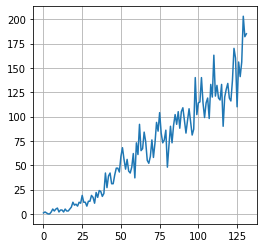

In [11]:
plt.figure(figsize=(4, 4));
plt.plot(series);
plt.grid(True)

# Building Model

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

def build_model():
    
    input_layer = tf.keras.Input(shape=(None, 1))
    
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=5, padding='causal', activation='relu')(input_layer)
    x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(32, return_sequences=True)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='relu')(x)
    
    output_layer = tf.keras.layers.Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

model = build_model()

model.summary()

# def piecewise_constant_fn(epoch):
#     if epoch < 110:
#         return 1e-4
#     elif epoch < 120:
#         return 1e-3  
#     else:
#         return 5e-3

# def piecewise_constant(boundaries, values):
#     boundaries = np.array([0] + boundaries)
#     values = np.array(values)
#     def piecewise_constant_fn(epoch):
#         return values[np.argmax(boundaries > epoch) - 1]
#     return piecewise_constant_fn

# piecewise_constant_fn = piecewise_constant([110, 120, ], [1e-4, 1e-3, 5e-3])
# lr_scheduler_pc = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=250)#, callbacks=[lr_scheduler_pc])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
dense (Dense)                (None, None, 32)          1056      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          330       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)          

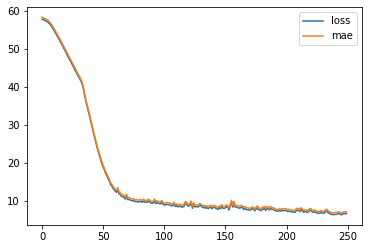

In [32]:
pd.DataFrame(history.history).plot();

# Plotting Func

In [33]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel('Value')
    plt.grid(True)

# Forecasting

In [34]:
split_time = 112

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

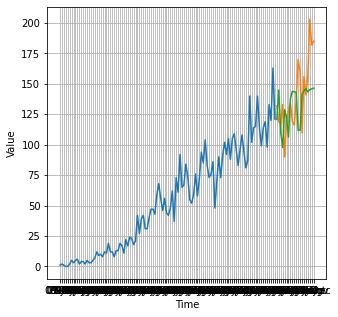

In [36]:
plt.figure(figsize=(5, 5))
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)